In [1]:
SANDBOX_NAME = 'fesc' # Sandbox Name
DATA_PATH = "/data/sandboxes/"+SANDBOX_NAME+"/data/"



# Spark ML Clustering

Haremos un **Análisis RFM** antes de aplicar un algoritmo de clustering.

**RFM** es un método usado para analizar el valor del cliente. Es habitualmente utilizado en bases de datos de marketing y marketing directo y recibe atención especial en los sectores de retail y servicios.

Las siglas RFM significan las tres dimensiones:

* Recency - *¿Cuánto tiempo hace desde la última compra del cliente?*

* Frequency - *¿Con qué frecuencia compra el cliente?*

* Monetary Value - *¿Cuánto gasta el cliente?*

RFM (customer value). (s.f.). En *Wikipedia*. Recuperado el 29 de Enero de 2019 de [https://en.wikipedia.org/wiki/RFM_(customer_value)](https://en.wikipedia.org/wiki/RFM_(customer_value))



### Crear SparkSession

In [2]:
# Respuesta

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()



### Cargar datos y comprobar schema

En este caso se utilizará el dataset 'Online Retail.csv'

In [3]:
# Respuesta

sales = spark.read.csv(DATA_PATH+'data/Online Retail.csv', sep='|', header=True, inferSchema=True)

sales.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [4]:
# Respuesta

sales.show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 8:26|     2,55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 8:26|     3,39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 8:26|     2,75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 8:26|     3,39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 8:26|     3,39|     17850|United Kingdom|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
only showing top 5 rows





#### Pasos previos

* Modificamos los tipos de las columnas CustomerID y de UnitPrice. Luego agrupamos por país y vemos las operaciones realizadas.

In [5]:
# Respuesta

from pyspark.sql.types import StringType, FloatType
import pyspark.sql.functions as F

sales = sales.withColumn('CustomerID', sales.CustomerID.astype(StringType()))
sales = sales.withColumn('UnitPrice', F.udf(lambda value: float(value.strip().replace(',','.')), FloatType())(F.col('UnitPrice')))

sales.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [6]:
# Respuesta

sales.count()

541909

In [7]:
# Respuesta

sales.groupBy("Country").count().orderBy('count', ascending=False).show()

+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|495478|
|        Germany|  9495|
|         France|  8557|
|           EIRE|  8196|
|          Spain|  2533|
|    Netherlands|  2371|
|        Belgium|  2069|
|    Switzerland|  2002|
|       Portugal|  1519|
|      Australia|  1259|
|         Norway|  1086|
|          Italy|   803|
|Channel Islands|   758|
|        Finland|   695|
|         Cyprus|   622|
|         Sweden|   462|
|    Unspecified|   446|
|        Austria|   401|
|        Denmark|   389|
|          Japan|   358|
+---------------+------+
only showing top 20 rows





* Vemos que la mayoría del histórico de los datos están en Reino Unido, restringimos los datos solo a los clientes de Reino Unido.

In [8]:
# Respuesta

sales_uk = sales[sales['Country']=='United Kingdom']

sales_uk.count()

495478



* Eliminar todos los nulos

In [9]:
# Respuesta
        
for element in sales_uk.columns:
    sales_uk = sales_uk.where(F.col(element).isNotNull())

# sales_uk = sales_uk.dropna() # Here is another option, instead of the for loop.
 
sales_uk.count()

361878



* Eliminar pedidos cancelados. Es decir, debemos quedarnos con aquellos registros donde la columna "Quantity" sea mayor que cero.

In [10]:
# Respuesta

sales_uk = sales_uk[sales_uk['Quantity']>0]

sales_uk.count()

354345



* Añadimos la columna precio total, debe llamarse "TotalPrice". Debe ser "Quantity" x "UnitPrice" 

In [11]:
# Respuesta

sales_uk = sales_uk.withColumn('TotalPrice', F.round(sales_uk.Quantity * sales_uk.UnitPrice,2))

sales_uk.show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 8:26|     2.55|     17850|United Kingdom|      15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|     20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 8:26|     2.75|     17850|United Kingdom|      22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|     20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|     20.34|
+---------+---------+--------------------+--------+---------------+---------+---



* Creamos una nueva columna, de formato _timestamp_, en base a la columna InvoiceDate 

In [12]:
# Respuesta

from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

sales_uk = sales_uk.withColumn('NewInvoiceDate',
                               to_utc_timestamp(unix_timestamp(col('InvoiceDate'),
                                          "dd/MM/yy HH:mm").cast('timestamp'), 'UTC'))
sales_uk.show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+--------------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|      NewInvoiceDate|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+--------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 8:26|     2.55|     17850|United Kingdom|      15.3|2010-12-01 08:26:...|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|     20.34|2010-12-01 08:26:...|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 8:26|     2.75|     17850|United Kingdom|      22.0|2010-12-01 08:26:...|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|     20.34|2010-12-01 08:26:...|
|   536365|   84029E|RED WOOLLY HOTTIE...|      



* Cálculo de Recency. Para el cálculo de recency asumimos que la fecha actual es el 30/12/2011

In [13]:
# Respuesta

current_ts = to_utc_timestamp( unix_timestamp(lit('30/12/2011 00:00'), \
                              "dd/MM/yy HH:mm").cast('timestamp'), 'UTC' )

sales_uk = sales_uk.withColumn('DaysBefore', datediff(lit(current_ts), 'NewInvoiceDate' ))

recency_df = sales_uk.groupBy('CustomerID').agg(F.min(sales_uk.DaysBefore).alias('Recency'))

In [14]:
sales_uk.orderBy('DaysBefore', ascending=True).show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+--------------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|      NewInvoiceDate|DaysBefore|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+--------------------+----------+
|   581475|    23239|SET OF 4 KNICK KN...|       6|09/12/2011 8:39|     1.65|     13069|United Kingdom|       9.9|2011-12-09 08:39:...|        21|
|   581475|    23235|STORAGE TIN VINTA...|      12|09/12/2011 8:39|     1.25|     13069|United Kingdom|      15.0|2011-12-09 08:39:...|        21|
|   581475|    23272|TREE T-LIGHT HOLD...|      12|09/12/2011 8:39|     0.39|     13069|United Kingdom|      4.68|2011-12-09 08:39:...|        21|
|   581475|    22596|CHRISTMAS STAR WI...|      36|09/12/2011 8:39|     0.39|     13069|United Kingdom|     14.04|2011

In [16]:
# Respuesta

recency_df.count()

3921

In [17]:
# Respuesta

recency_df.show(5)

+----------+-------+
|CustomerID|Recency|
+----------+-------+
|     16250|    282|
|     15574|    198|
|     15555|     33|
|     15271|     28|
|     17714|    341|
+----------+-------+
only showing top 5 rows





* Cálculo de Frequency.

In [18]:
# Respuesta

frequency_df = sales_uk.groupBy('CustomerID', 'InvoiceNo').count()  \
                      .groupBy('CustomerID')                       \
                      .agg(F.count("*").alias("Frequency"))

In [19]:
# Respuesta

frequency_df.count()

3921



* Cálculo de Monetary.

In [20]:
# Respuesta

monetary_df = sales_uk.groupBy('CustomerID').agg(F.round(F.sum('TotalPrice'),2).alias('Monetary'))

In [21]:
# Respuesta

monetary_df.show(5)

+----------+--------+
|CustomerID|Monetary|
+----------+--------+
|     16250|  389.44|
|     15574|  702.25|
|     15555| 4805.17|
|     15271| 2507.07|
|     17714|   153.0|
+----------+--------+
only showing top 5 rows



In [22]:
# Respuesta
monetary_df.count()

3921



* Unimos los valores de RFM por CustomerID

In [23]:
# Respuesta

mf_df = monetary_df.join(frequency_df,                              \
      monetary_df.CustomerID == frequency_df.CustomerID, 'inner') \
      .drop(frequency_df.CustomerID)

rfm_df =  mf_df.join(recency_df,                              \
        recency_df.CustomerID == mf_df.CustomerID, 'inner') \
        .drop(recency_df.CustomerID)

rfm_df = rfm_df.select( 'CustomerID', 'Recency', 'Frequency', 'Monetary' )
rfm_df.cache()

DataFrame[CustomerID: string, Recency: int, Frequency: bigint, Monetary: double]

In [24]:
rfm_df.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     12847|     43|        1|  871.54|
|     13192|    116|        2|  911.94|
|     13282|     39|        3| 1132.14|
|     13610|     33|        7| 1131.88|
|     13772|     54|        3| 1132.13|
+----------+-------+---------+--------+
only showing top 5 rows





* VectorAssembler con variables deseadas

In [25]:
# Respuesta

from pyspark.ml.feature import VectorAssembler

features_to_assemble = ['Recency', 'Frequency', 'Monetary']

vector_assembler = VectorAssembler(inputCols = features_to_assemble, outputCol = 'assembled_features')

rfm_df = vector_assembler.transform(rfm_df).cache()

rfm_df.show(5)

+----------+-------+---------+--------+------------------+
|CustomerID|Recency|Frequency|Monetary|assembled_features|
+----------+-------+---------+--------+------------------+
|     12847|     43|        1|  871.54| [43.0,1.0,871.54]|
|     13192|    116|        2|  911.94|[116.0,2.0,911.94]|
|     13282|     39|        3| 1132.14|[39.0,3.0,1132.14]|
|     13610|     33|        7| 1131.88|[33.0,7.0,1131.88]|
|     13772|     54|        3| 1132.13|[54.0,3.0,1132.13]|
+----------+-------+---------+--------+------------------+
only showing top 5 rows





* StandardScaler con variables cuantitativas ('Recency', 'Frequency', 'Monetary')

In [26]:
# Respuesta

from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='assembled_features', outputCol='features_scaled')
standard_scaler_model = standard_scaler.fit(rfm_df)
rfm_df = standard_scaler_model.transform(rfm_df)

In [27]:
rfm_df.show(5)

+----------+-------+---------+--------+------------------+--------------------+
|CustomerID|Recency|Frequency|Monetary|assembled_features|     features_scaled|
+----------+-------+---------+--------+------------------+--------------------+
|     12847|     43|        1|  871.54| [43.0,1.0,871.54]|[0.43203691518006...|
|     13192|    116|        2|  911.94|[116.0,2.0,911.94]|[1.16549493397413...|
|     13282|     39|        3| 1132.14|[39.0,3.0,1132.14]|[0.39184743469820...|
|     13610|     33|        7| 1131.88|[33.0,7.0,1131.88]|[0.33156321397540...|
|     13772|     54|        3| 1132.13|[54.0,3.0,1132.13]|[0.54255798650520...|
+----------+-------+---------+--------+------------------+--------------------+
only showing top 5 rows





### KMeans



* Se debe estudiar cual es el mejor valor de K (utilizando el dataframe "rfm_df")

In [28]:
# Respuesta

from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

values_for_graph = []

for k_value in range(2,11):
    print(k_value)
    
    k_means = KMeans(featuresCol = 'features_scaled', k=k_value, seed=4)
    k_means_model = k_means.fit(rfm_df)
    cost = k_means_model.computeCost(rfm_df)
    
    values_for_graph.append((k_value, cost))

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


2
3
4
5
6
7
8
9
10


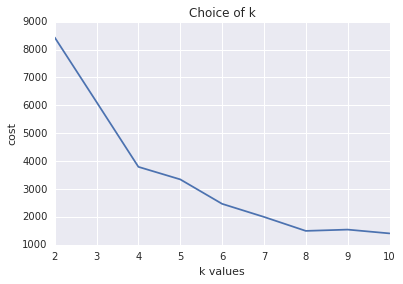

In [29]:
# Respuesta

sns.set()
plt.plot([element[0] for element in values_for_graph], [element[1] for element in values_for_graph])
plt.xlabel('k values')
plt.ylabel('cost')
plt.title('Choice of k')



* La técnica del codo

Es común realizar un gráfico 2D para saber qué valor de K elegir. Normalmente en las absisas se coloca el número de clusters y en la ordenadas se suele colocar un métrica  de costo que permita cuantificar la calidad de los clusters, por ejemplo: la suma de las distancias al cuadrado de los puntos al centro más cercano (ver la documentacion con el método _computeCost_).
A mayor número de K, la métrica de costo tiene a disminuir. Se debe elegir aquel máximo valor de K tenga una disminución significativa del costo.

En este caso particular se debería apreciar que pasar de K=7 a un K=8 disminuye a la mitad el costo. Sin embargo, aumentar el valor de K=9 no tiene un impacto significativo en el costo. Por estas razones deberíamos elegir K = 8.

In [30]:
# Respuesta

k_means = KMeans(featuresCol = 'features_scaled', k=8, seed=4)
k_means_model = k_means.fit(rfm_df)
sales_kmeans = k_means_model.transform(rfm_df)

sales_kmeans.show(5)

+----------+-------+---------+--------+------------------+--------------------+----------+
|CustomerID|Recency|Frequency|Monetary|assembled_features|     features_scaled|prediction|
+----------+-------+---------+--------+------------------+--------------------+----------+
|     12847|     43|        1|  871.54| [43.0,1.0,871.54]|[0.43203691518006...|         0|
|     13192|    116|        2|  911.94|[116.0,2.0,911.94]|[1.16549493397413...|         0|
|     13282|     39|        3| 1132.14|[39.0,3.0,1132.14]|[0.39184743469820...|         0|
|     13610|     33|        7| 1131.88|[33.0,7.0,1131.88]|[0.33156321397540...|         3|
|     13772|     54|        3| 1132.13|[54.0,3.0,1132.13]|[0.54255798650520...|         0|
+----------+-------+---------+--------+------------------+--------------------+----------+
only showing top 5 rows





* Vemos la frecuencia de cada cluster.

In [31]:
# Respuesta

sales_kmeans.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2034|
|         1|  689|
|         2|   17|
|         3|  540|
|         4|  539|
|         5|    3|
|         6|    6|
|         7|   93|
+----------+-----+





¿Qué piensa de los grupos y su distribución?



* Calculamos la media de los valores de RFM para cada cluster.

In [32]:
# Respuesta

sales_cluster_centers = sales_kmeans.groupBy('prediction').agg(F.round(F.mean('Recency'),2).alias('Recency'), \
                                                                F.round(F.mean('Frequency'),2).alias('Frequency'), \
                                                                F.round(F.mean('Monetary'),2).alias('Monetary'))

sales_cluster_centers.orderBy('prediction').show()

+----------+-------+---------+---------+
|prediction|Recency|Frequency| Monetary|
+----------+-------+---------+---------+
|         0|  59.09|     2.68|   894.65|
|         1| 181.23|     2.07|   627.64|
|         2|  71.82|    31.88| 56054.17|
|         3|  41.14|     9.85|  3643.58|
|         4| 316.09|      1.3|   371.29|
|         5|  23.67|     36.0|207560.19|
|         6|  22.17|   116.83| 36275.27|
|         7|  31.44|    25.89| 11777.61|
+----------+-------+---------+---------+





### BisectingKMeans

In [33]:
# Respuesta

from pyspark.ml.clustering import BisectingKMeans

bisectingkmeans = BisectingKMeans(featuresCol='features_scaled', seed=4, k=8)
bisectingkmeans_model = bisectingkmeans.fit(rfm_df)
sales_bisectingkmeans = bisectingkmeans_model.transform(rfm_df)

sales_bisectingkmeans.show()

+----------+-------+---------+--------+-------------------+--------------------+----------+
|CustomerID|Recency|Frequency|Monetary| assembled_features|     features_scaled|prediction|
+----------+-------+---------+--------+-------------------+--------------------+----------+
|     12847|     43|        1|  871.54|  [43.0,1.0,871.54]|[0.43203691518006...|         0|
|     13192|    116|        2|  911.94| [116.0,2.0,911.94]|[1.16549493397413...|         0|
|     13282|     39|        3| 1132.14| [39.0,3.0,1132.14]|[0.39184743469820...|         0|
|     13610|     33|        7| 1131.88| [33.0,7.0,1131.88]|[0.33156321397540...|         0|
|     13772|     54|        3| 1132.13| [54.0,3.0,1132.13]|[0.54255798650520...|         0|
|     13865|     79|        4|  501.56|  [79.0,4.0,501.56]|[0.79374223951686...|         0|
|     14157|     40|        2|  432.88|  [40.0,2.0,432.88]|[0.40189480481866...|         0|
|     14204|     23|        1|  161.03|  [23.0,1.0,161.03]|[0.23108951277073...|



* Vemos la frecuencia de cada cluster.

In [34]:
# Respuesta

sales_bisectingkmeans.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  287|
|         6|  276|
|         3|    3|
|         5|  257|
|         4|  306|
|         7|  175|
|         2|   19|
|         0| 2598|
+----------+-----+





* Calculamos la media de los valores de RFM para cada cluster.

In [35]:
# Respuesta

sales_cluster_centers = sales_bisectingkmeans.groupBy('prediction').agg(F.round(F.mean('Recency'),2).alias('Recency'), \
                                                                F.round(F.mean('Frequency'),2).alias('Frequency'), \
                                                                F.round(F.mean('Monetary'),2).alias('Monetary'))

sales_cluster_centers.orderBy('prediction').show()

+----------+-------+---------+---------+
|prediction|Recency|Frequency| Monetary|
+----------+-------+---------+---------+
|         0|  63.55|     3.36|  1152.21|
|         1|  35.04|    17.16|  7590.03|
|         2|  26.21|    66.84| 49710.91|
|         3|  23.67|     36.0|207560.19|
|         4| 185.18|      1.9|   489.37|
|         5| 240.83|     1.65|   662.07|
|         6| 299.76|     1.39|   411.62|
|         7| 371.17|      1.3|   776.63|
+----------+-------+---------+---------+

